In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import torch

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F


from fase.nn.conv import *

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


In [3]:
num_workers = 0
batch_size = 32
valid_size = 0.2


## Scale 
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True,
                              transform=transform
                             )
test_data = datasets.CIFAR10('data', train=False,
                             download=True, 
                             transform=transform
                            )

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [21]:
import ResNet20
from approximate import approx_relu, approx_sign

activation = lambda x : 40 * approx_relu(x/40, degree = 4, repeat=3)

org_model = ResNet20.ResNet9(activation=activation)

# FHE

In [5]:
#import fase
from fase.core import seal_ckks
from fase.core.seal_ckks import SEALContext
from fase.seal import Ciphertext

poly_modulus_degree = 16384
coeff_moduli = [37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=28)

In [135]:
poly_modulus_degree = 2**15
scale_bit = 50
coeff_moduli = [60] + [scale_bit] * 14 + [60]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=scale_bit)

SEAL CKKS scheme is ready


## Load image

In [136]:
import torchvision.transforms as transforms

img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

torch.Size([1, 3, 32, 32])


## Load trained parameters

In [137]:
#fn_param = "SimpleCNN_ReLU_minimax.pt"
fn_param = "ResNet9avg_minimaxReLU.pt"
trained_param = torch.load(fn_param)
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

In [138]:
org_model

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (basicblock1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

# ResNet: 0. Early Layers

In [139]:
import fase.nn.utils as utils
util = utils.Seal_checker(sec)

### Input is normalized to [0,1]

In [140]:
#img_this_example = img_tensor[0] # Assume batch size = 1
#img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]


#util.check_decrypt(img_enc[0])

print(img_tensor.min(), img_tensor.max())

tensor(0.0824) tensor(1.)


#### 0.1 Convolution

In [141]:
print(org_model.conv1.weight.shape)
print(org_model.conv1)
tmp1, _nh2, _nw2 = my_conv2D_FHE(sec, img_enc, nh, nw, org_model.conv1.weight) # list of ctxts

org_tt0 = org_model.conv1(img_tensor)

torch.Size([64, 3, 3, 3])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output image size 32 32
len(rotated) 9


average diff 3.47%


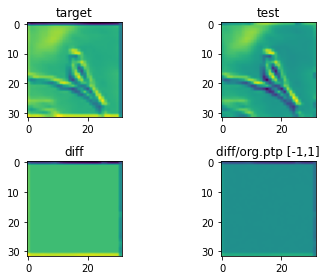

Scale 50.0
chain index 12
expected chain index = 11


In [142]:
util.plot_diff(org_tt0, tmp1, 32,32, ch=3)
util.check_ctxt(tmp1[0])
print("expected chain index = 11")

#### 0.2 BN

BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
average diff 0.00%


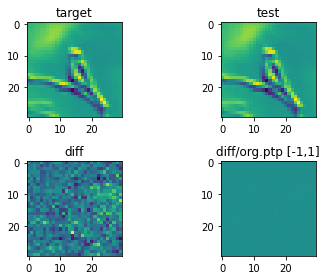

Scale 50.0
chain index 11
expected chain index = 10


In [143]:
print(org_model.bn1)

# FHE
tmp2 = fhe_bn(sec, tmp1, org_model.bn1)

# Torch
org_tt1 = org_model.bn1(org_tt0)

util.plot_diff(org_tt1, tmp2, 32,32, ch=3, offset=1)
util.check_ctxt(tmp2[0])
print("expected chain index = 10")

diff는 거의 0임.

Conv에서는 multByConst만 있으나 이거도 Scale을 똑같이 증가시키는가 봄..  
C_mult와 다른 점은, multByConst 후에는 relinearization은 필요 없고 rescale만 해주면 됨.  
연산을 거친 ctxt의 level과 새로 encoding된 ptxt의 level이 다름. scale도 같고, level도 맞아야함. (mod_switch_to_inplace)

#### 0.3 activation   

In [144]:
from fase.core import commonAlgo
from fase.core.commonAlgo import CommonAlgorithms
from numpy import polynomial as P

calgo = CommonAlgorithms(sec, "SEAL")

정확도를 높이려면 더 많은 bit가 필요함. [60, 40, ...., 60?]

연산에 오차가 있는 것 보다도, xx를 encrypt할 때 추가되는 오차가 이미 너무 큰 걸수도. 

f(x) ~ x^4 인 계산을 두 번 나누어서 하는 건 문제가 없음!  
한번에 x^8까지 계산하는게 문제임. 


1. 높은 차수의 polynomial을 임의의 낮은 차수로 factoring하는 방법은...?  
coeff가 real number 이므로 어차피 손으로는 못 함.  
https://www.coursera.org/lecture/converter-control/8-1-8-analytical-factoring-of-higher-order-polynomials-6vTUc
근사적인 방법이 있는 듯?  

이전에 참조하려다 이해 못했던 그 논문도 비슷한 생각으로 진행했던 거였나 봄. 


2. 애초에 왜 polyeval 함수 계산이라고 왜 문제가 되어야하나. 어차피 한 번에 한 차수씩 곱하지 않나? 


In [145]:
from numpy import polynomial as P
import math 

repeat = 3

In [146]:
ff = approx_sign(5)

In [147]:
ff.coef

array([ 0.        ,  2.70703125,  0.        , -4.51171875,  0.        ,
        5.4140625 ,  0.        , -3.8671875 ,  0.        ,  1.50390625,
        0.        , -0.24609375])

### Approximate RELU!!!!

Org range -12.001448239224898 13.998785268270849
factor 20
range after the first f(x) -0.9767143660925559 0.9946808831423324
Scale 40.0
chain index 14
range after the second f(x) -1.0000045417601857 1.0000055534000103
range after the third f(x) -1.0000030679162801 1.0000033705961147
Scale 40.0
chain index 11
Scale 80.0
chain index 3


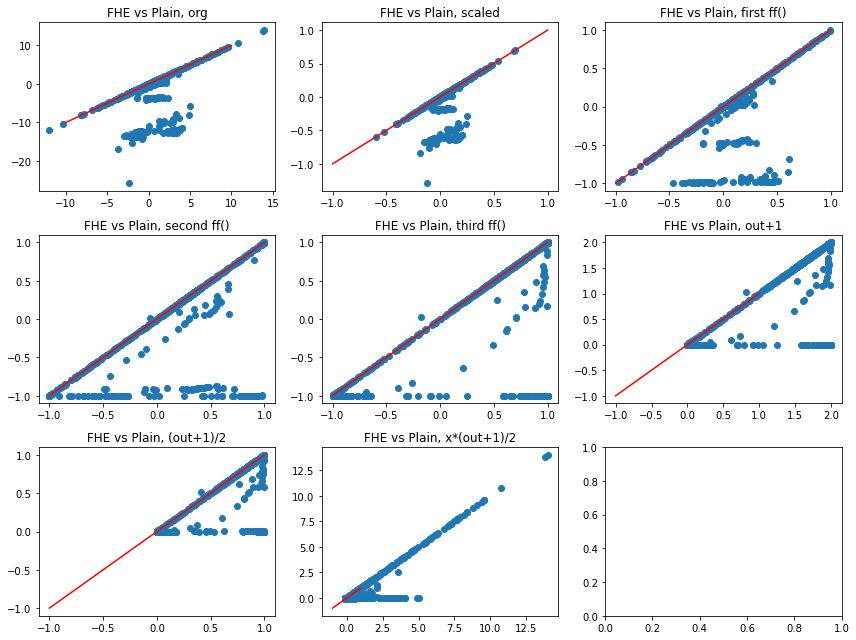

In [98]:
debug = False
fig, axs = plt.subplots(3,3, figsize=(12,9))

xfactor = 20
iind = 14

ctx = tmp2[iind]
tmp1 = sec.decrypt(ctx)
print("Org range",tmp1.min(), tmp1.max())
print("factor", xfactor)


if debug:
    util.check_ctxt(ctx)
    util.check_decrypt(ctx)

org = org_tt1[0,iind,:,:].detach().numpy().ravel()
dec0 = sec.decrypt(ctx)[:len(org)]

# Check 1:1 correlation b/w FHE and ORG
axs[0,0].scatter(dec0, org)
axs[0,0].plot(np.linspace(-10,10),np.linspace(-10,10), c='r')
axs[0,0].set_title("FHE vs Plain, org")


scaled = sec.multByConst(ctx, 1/xfactor, rescale=True, broadcast=True, inplace=False)

if debug:
    util.check_ctxt(scaled)
    util.check_decrypt(scaled)

# Check 1:1 correlation b/w FHE and ORG
axs[0,1].scatter(sec.decrypt(scaled)[:1024], org/xfactor)
axs[0,1].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[0,1].set_title("FHE vs Plain, scaled")


oo1 = ff(org/xfactor)
tmp = calgo.function_poly(ff.coef, scaled)

if debug:
    util.check_ctxt(tmp)
    util.check_decrypt(tmp)

dec = sec.decrypt(tmp)
print("range after the first f(x)", dec.min(), dec.max())

# Check 1:1 correlation b/w FHE and ORG
axs[0,2].scatter(dec[:1024], oo1)
axs[0,2].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[0,2].set_title("FHE vs Plain, first ff()")

#Chain index starts from 14.  
#one function_poly call reduces the chain index by 5

tmp = sec.decrypt(tmp)
tmp = sec.encrypt(tmp)

util.check_ctxt(tmp)
oo2 = ff(oo1)

tmp = calgo.function_poly(ff.coef, tmp)
if debug:
    util.check_ctxt(tmp)
    util.check_decrypt(tmp)

dec = sec.decrypt(tmp)
print("range after the second f(x)", dec.min(), dec.max())

# Check 1:1 correlation b/w FHE and ORG
axs[1,0].scatter(dec[:1024], oo2)
axs[1,0].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[1,0].set_title("FHE vs Plain, second ff()")

tmp = calgo.function_poly(ff.coef, tmp)
if debug:
    util.check_ctxt(tmp)
    util.check_decrypt(tmp)

dec = sec.decrypt(tmp)
print("range after the third f(x)", dec.min(), dec.max())

oo3 = ff(oo2)

# Check 1:1 correlation b/w FHE and ORG
axs[1,1].scatter(dec[:1024], oo3)
axs[1,1].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[1,1].set_title("FHE vs Plain, third ff()")

# (out + 1)
sec.addConst(tmp, np.ones(1024), inplace=True)
if debug:
    util.check_ctxt(tmp)
    util.check_decrypt(tmp)

oo4 = oo3 + 1

# Check 1:1 correlation b/w FHE and ORG
axs[1,2].scatter(sec.decrypt(tmp)[:1024], oo4)
axs[1,2].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[1,2].set_title("FHE vs Plain, out+1")

# (out + 1) / 2
sec.multByConst(tmp, 0.5, inplace=True, rescale=True, broadcast=True)

if debug:
    util.check_ctxt(tmp)
    util.check_decrypt(tmp)

oo5 = oo4/2

# Check 1:1 correlation b/w FHE and ORG
axs[2,0].scatter(sec.decrypt(tmp)[:1024], oo5)
axs[2,0].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[2,0].set_title("FHE vs Plain, (out+1)/2")

#Mod mismatch between ctx and tmp
util.check_ctxt(ctx)
sec.match_mod(ctx, tmp)

# x * (out + 1) /2
sec.mult(tmp, ctx, inplace=True)
util.check_ctxt(tmp)

oo6 = oo5 * org

axs[2,1].scatter(sec.decrypt(tmp)[:1024], oo6)
axs[2,1].plot(np.linspace(-1,1),np.linspace(-1,1), c='r')
axs[2,1].set_title("FHE vs Plain, x*(out+1)/2")

plt.tight_layout()

어디서 살짝 틀어짐..?

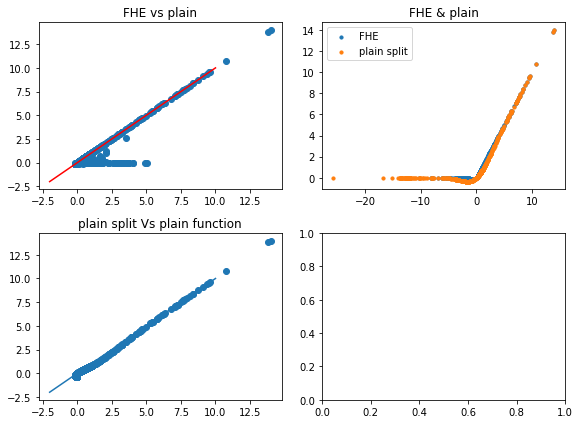

In [104]:
org_tt2 = org_model.activation(org_tt1)
result = org_tt2[0,iind,:,:].detach().numpy().ravel()

fig, axs = plt.subplots(2,2, figsize=(8,6))
#plt.scatter(dec0, sec.decrypt(tmp)[:len(org)])
axs[0,0].scatter(sec.decrypt(tmp)[:len(org)], oo6)
axs[0,0].plot(np.linspace(-2,10),np.linspace(-2,10), 'r')
axs[0,0].set_title("FHE vs plain")


axs[0,1].scatter(dec0, sec.decrypt(tmp)[:len(org)], label="FHE", s=10)
axs[0,1].scatter(org, result, label="plain split", s=10)
axs[0,1].set_title("FHE & plain")
axs[0,1].legend()


axs[1,0].scatter(oo6, result)
axs[1,0].plot(np.linspace(-2,10),np.linspace(-2,10))
axs[1,0].set_title("plain split Vs plain function")


plt.tight_layout()


계산 모양은 맞는데 에러가 조금 있음.  
1. 40배로 줄이는건 너무 심한 듯
2. degree를 높여볼까? 한 번에 한 chain 다 쓰도록? 

함수로 정리한 뒤에 파라미터만 조금씩 바꿔보기. 

In [148]:
def do_bootstrap(ctxt):
    ctxt = sec.decrypt(ctxt)
    return sec.encrypt(ctxt)

poly_mult_depth = 5

def approx_relu_fhe(ctxts, ff, xfactor = 20):
    output = []
    for ictx, ctx in enumerate(ctxts):
        #tmp1 = sec.decrypt(ctx)
        #print("Org range",tmp1.min(), tmp1.max())
        #print("factor", xfactor)

        scaled = sec.multByConst(ctx, 1/xfactor, rescale=True, broadcast=True, inplace=False)

        tmp = calgo.function_poly(ff.coef, scaled)

        #Chain index starts from 14.  
        #one function_poly call reduces the chain index by 5
        ######################
        #tmp = sec.decrypt(tmp)
        #tmp = sec.encrypt(tmp)
        
        
        ######################
        for _ in range(1,repeat):
            if sec.context.get_context_data(tmp.parms_id()).chain_index() < poly_mult_depth:
                tmp = do_bootstrap(tmp)
                print("Bootstrapped", ictx, _)
            tmp = calgo.function_poly(ff.coef, tmp)
            #tmp = calgo.function_poly(ff.coef, tmp)

        # (out + 1)
        sec.addConst(tmp, np.ones(1024), inplace=True)
        # (out + 1) / 2
        sec.multByConst(tmp, 0.5, inplace=True, rescale=True, broadcast=True)

        #Mod mismatch between ctx and tmp
        sec.match_mod(ctx, tmp)

        # x * (out + 1) /2
        sec.mult(tmp, ctx, inplace=True)

        output.append(tmp)
    return output

In [149]:
# fhe
tmp3 = approx_relu_fhe(tmp2, ff)#, repeat=3)

# pytorch
org_tt2 = org_model.activation(org_tt1)

Bootstrapped 0 2
Bootstrapped 1 2
Bootstrapped 2 2
Bootstrapped 3 2
Bootstrapped 4 2
Bootstrapped 5 2
Bootstrapped 6 2
Bootstrapped 7 2
Bootstrapped 8 2
Bootstrapped 9 2
Bootstrapped 10 2
Bootstrapped 11 2
Bootstrapped 12 2
Bootstrapped 13 2
Bootstrapped 14 2
Bootstrapped 15 2
Bootstrapped 16 2
Bootstrapped 17 2
Bootstrapped 18 2
Bootstrapped 19 2
Bootstrapped 20 2
Bootstrapped 21 2
Bootstrapped 22 2
Bootstrapped 23 2
Bootstrapped 24 2
Bootstrapped 25 2
Bootstrapped 26 2
Bootstrapped 27 2
Bootstrapped 28 2
Bootstrapped 29 2
Bootstrapped 30 2
Bootstrapped 31 2
Bootstrapped 32 2
Bootstrapped 33 2
Bootstrapped 34 2
Bootstrapped 35 2
Bootstrapped 36 2
Bootstrapped 37 2
Bootstrapped 38 2
Bootstrapped 39 2
Bootstrapped 40 2
Bootstrapped 41 2
Bootstrapped 42 2
Bootstrapped 43 2
Bootstrapped 44 2
Bootstrapped 45 2
Bootstrapped 46 2
Bootstrapped 47 2
Bootstrapped 48 2
Bootstrapped 49 2
Bootstrapped 50 2
Bootstrapped 51 2
Bootstrapped 52 2
Bootstrapped 53 2
Bootstrapped 54 2
Bootstrapped 55 2
Bo

average diff 16.92%


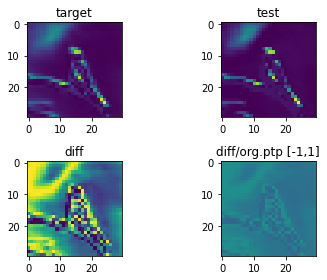

Scale 100.0
chain index 8
expected chain index = 8


In [150]:
util.plot_diff(org_tt2, tmp3, nh, nw, ch=3, offset=1)
util.check_ctxt(tmp3[0])
print("expected chain index = 8")

16.92% error after FHE ReLU. Not too bad. 

As you can see below, the difference is solely due to the approximation error

now I can proceed with no problem (except the incorrect padding..)

# ResNet: 1. Basic Block

In [31]:
from fase.nn.conv import *

In [32]:
org_model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
)

In [35]:
# One block = ((Conv2D - BN - ReLU - Conv2D - Bn ) + () ) ReLU

def to_numpy(tensor):
    return tensor.detach().numpy()

In [36]:
layer1_0 = org_model.layer1._modules['0']

ctxts_in = res

# Layer1_0.conv1

# fhe
print("Conv shape", layer1_0.conv1.weight.shape)
print(layer1_0.conv1)
tmp_l0, _, _ = my_conv2D_FHE(sec, ctxts_in, nh, nw, layer1_0.conv1.weight)
tt = sec.decrypt(tmp_l0[3])[:nh*nw].reshape(nh,nw)
print("1", tt[12:16,12:16])

# pytorch
org_tt_l0 = layer1_0.conv1(org_tt2)

Conv shape torch.Size([16, 16, 3, 3])
Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output image size 32 32
1 [[-1.47738188 -2.03776531 -1.86142907 -0.20562326]
 [-1.49211577 -2.09064627 -1.74632777 -0.19414624]
 [-1.52217365 -2.13134247 -1.65054832 -0.03526547]
 [-1.54287543 -2.15197071 -1.67301825 -0.01510973]]


average diff 13.96%


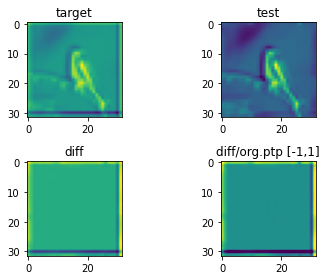

Scale 28.0
chain index 11


In [37]:
util.plot_diff(org_tt_l0, tmp_l0, nh, nw, ch=3)
util.check_ctxt(tmp_l0[0])

### ReLU때문에 계산이 틀리면 decrypt 후에 plain으로 계산. (o)
### ResNet 끝까지 완성한 뒤에 ReLU는 적당한 정확도의 모듈로 갈아끼우기 (o)
# 그보다 마지막 softmax를 evaluate할 때는 무시해도 되는지 확인 해봐야함. 

In [38]:
# conv1 - bn1 - activatoin - conv2 - bn2 - shortcut - activation
layer1_0 

BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

Everything is good!

In [39]:
# this_layer
def layer10(sec, ctxts_in, nh, nw, this_layer):
    tmp_l0, out_nh, out_nw = my_conv2D_FHE(sec, ctxts_in, nh, nw, this_layer.conv1.weight)
    tmp0 = fhe_bn(sec, tmp_l0, this_layer.bn1)
    #tt = sec.decrypt(tmp0[3])[:nh*nw].reshape(nh,nw)
    #print("2", tt[12:18,12:18])
    tmp0 = fake_relu(sec, tmp0, nh, nw, this_layer.activation)
    #tt = sec.decrypt(tmp0[3])[:nh*nw].reshape(nh,nw)
    #print("3", tt[12:18,12:18])
    tmp0, out_nh, out_nw = my_conv2D_FHE(sec, tmp0, nh, nw, this_layer.conv2.weight)
    #tt = sec.decrypt(tmp0[3])[:nh*nw].reshape(nh,nw)
    #print("4", tt[12:18,12:18])
    tmp0 = fhe_bn(sec, tmp0, this_layer.bn2)
    #tt = sec.decrypt(tmp0[3])[:nh*nw].reshape(nh,nw)
    #print("5", tt[12:18,12:18])

    out = []
    for ctxt0, ctxt1 in zip(tmp0, ctxts_in):
        # Match mod
        sec.match_mod(ctxt1, ctxt0)
        sec.add(ctxt0, ctxt1, inplace=True)
        out.append(ctxt0)
    
    util.check_ctxt(out[0])
    return fake_relu(sec, out, nh, nw, this_layer.activation)


In [40]:
# Final version
after_l0 = layer10(sec, res, nh, nw, org_model.layer1._modules['0'])

Output image size 32 32
Output image size 32 32
Scale 28.0
chain index 10


average diff 13.56%


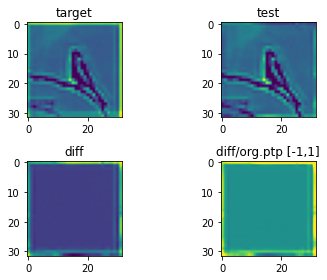

In [41]:
util.plot_diff(layer1_0(org_tt2), after_l0, nh, nw, ch=3)

## Layer 1-1

In [46]:
l11 = org_model.layer1._modules['1']
print(l11)

l1_org = org_model.layer1(org_tt2)
l1_org.shape

BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)


torch.Size([1, 16, 32, 32])

원본의 이미지 크기변화, 채널 수 변화에 유의. 

l1-0과 l1-1은 같은 모양인 듯. 

In [ ]:
decs = np.stack([sec.decrypt(ctxt)[:nh*nw] for ctxt in ctxts])
activated = relu(torch.tensor(decs))
    
[sec.encrypt(plain) for plain in activated]

In [ ]:
util.check(after_l0[0])

In [47]:
after_l1 = layer10(sec, after_l0, nh, nw, org_model.layer1._modules['1'])

Output image size 32 32
Output image size 32 32
Scale 28.0
chain index 10


In [48]:
util.check_ctxt(after_l0[0])
util.check_ctxt(after_l1[0])

Scale 28.0
chain index 10
Scale 28.0
chain index 13


average diff 19.53%


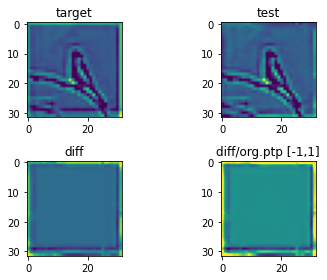

In [49]:
util.plot_diff(l1_org, after_l1, nh, nw, ch=3)

average diff 1.16%


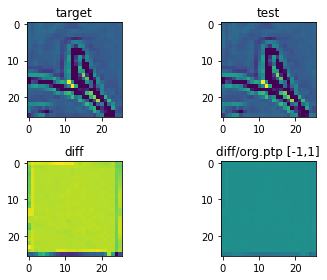

In [52]:
dec = util.plot_diff(l1_org, after_l1, 32, 32, ch=3, out=True, vmin=-1, vmax=1, offset=3)

GOOD!

## Layer2 

This time, the shorcut has a convolution with different kernel size

In [53]:
l20 = org_model.layer2._modules['0']

l20

BasicBlock(
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [96]:
cv1, nh2, nw2 = my_conv2D_FHE(sec, after_l1, nh, nw, l20.conv1.weight, stride=l20.conv1.stride[0]) # stride=2

nh2 = nw2 = 16

ocv1 = l20.conv1(l1_org)

Output image size 16 16


average diff 16.05%


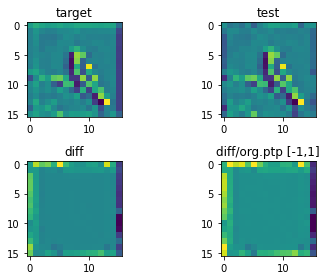

In [97]:
util.plot_diff(ocv1, cv1, nh, nw, ch=3, stride=(2,2))

In [99]:
tmp20 = fhe_bn(sec, cv1, l20.bn1)
otmp20 = l20.bn1(ocv1)

average diff 6.08%


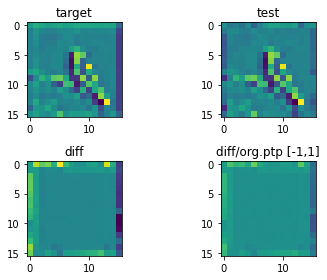

In [100]:
util.plot_diff(otmp20, tmp20, nh, nw, ch=3, stride=(2,2))

average diff 3.10%


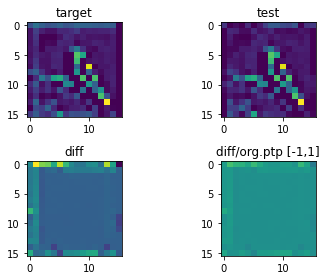

In [101]:
tmp20 = fake_relu(sec, tmp20, nh, nw, l20.activation)
otmp20 = l20.activation(otmp20)

util.plot_diff(otmp20, tmp20, nh, nw, ch=3, stride=(2,2))

strided ctxt에 그냥 convolution을 하면 [1,0,2,0,3,0] 중에서 [1,2,3]에 kernel을 씌우지 않고 [0,2,0]에 kernel을 씌우게 됨. 
  따라서 kernel을 흩뿌려줘야함. 


1. 3x3 kernel이 5x5 (혹은 6x6)이 되면 padding도 바뀔 수 있으니 조심.  
2. rotate을 9번 하는게 아니라 25 / 36번 하게 됨. 근데 9번 이외에는 낭비임. 
3. 

In [108]:
kernel[0,0]

array([[ 0.02753327, -0.03451015,  0.04716027],
       [-0.11999013, -0.05990485, -0.07925134],
       [ 0.00634806,  0.01131319,  0.05973209]], dtype=float32)

In [110]:
# dilate the kernel 
stride = (2,2)

kk = kernel[0,0]

zz = np.zeros((10,10))
zz[::2,::2] = kk

ValueError: could not broadcast input array from shape (3,3) into shape (5,5)

kernel은 항상 양 끝에 값이 들어가고, empty로 끝나지 않음.   
따라서 홀수던 짝수던 아래와 같은 식이 성립함  
`dilated_size = 2 * np.array(kk.shape) - 1  `  
개념적으로는 그런데.. 실제로는 kernel의 값 하나씩 계산이 들어가므로 kernel 모양을 미리 바꿔둘 필요가 없음.  

```
def convolv_fhe(): 
    ...
    output = []
    for each_kernel_value, rr in zip(raveled_kernel, rotated_ctxt): 
        output.append(multByConst(rr, each_kernel_value) and accumulate
```  
    
대신, rotation을 띄엄띄엄 하면 됨. 

In [104]:
kernel = l20.conv2.weight.detach().numpy()

In [106]:
kernel[0,0]

array([[ 0.02753327, -0.03451015,  0.04716027],
       [-0.11999013, -0.05990485, -0.07925134],
       [ 0.00634806,  0.01131319,  0.05973209]], dtype=float32)

Scale 28.0
chain index 13
Output image size 32 32
Scale 28.0
chain index 13
average diff 45.05%


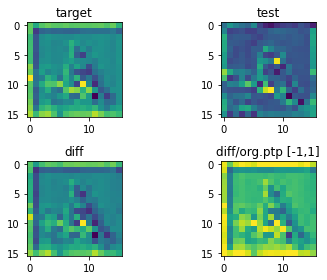

In [102]:
util.check_ctxt(tmp20[0])
tmp20z, out_nh, out_nw = my_conv2D_FHE(sec, tmp20, nh, nw, l20.conv2.weight)
util.check_ctxt(tmp20[0])

otmp20z = l20.conv2(otmp20)
util.plot_diff(otmp20z, tmp20z, nh, nw, ch=3, stride=(2,2))

In [93]:
util.check_ctxt(tmp20[0])

Scale 28.0
chain index 11


average diff 93.17%


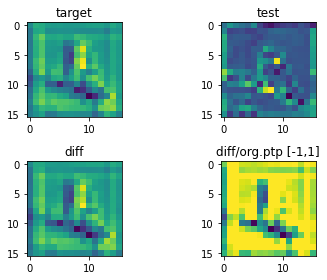

In [92]:
util.plot_diff(otmp20, tmp20, nh, nw, ch=3, stride=(2,2))

In [91]:
otmp20 = l20.conv2(otmp20)

In [ ]:
tmp20 = fhe_bn(sec, tmp20, l20.bn2)
otmp20 = l20.bn2(otmp20)
util.plot_diff(otmp20, tmp20, nh, nw, ch=3, stride=(2,2))

In [ ]:
#tt = sec.decrypt(tmp0[3])[:nh*nw].reshape(nh,nw)
#print("5", tt[12:18,12:18])

out = []
for ctxt0, ctxt1 in zip(tmp0, ctxts_in):
    # Match mod
    sec.match_mod(ctxt1, ctxt0)
    sec.add(ctxt0, ctxt1, inplace=True)
    out.append(ctxt0)

util.check_ctxt(out[0])
return fake_relu(sec, out, nh, nw, this_layer.activation)

In [54]:
conv_s, bn_s = l20.shortcut

print(conv_s)
print(bn_s)

Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [55]:
conv_s.weight.shape

torch.Size([32, 16, 1, 1])

In [56]:
conv_s.weight[0,0]

tensor([[0.0042]], grad_fn=<SelectBackward0>)

In [ ]:
shortcut, nh2, nw2 = my_conv2D_FHE1x1(sec, after_l1, nh, nw, conv_s.weight, stride=conv_s.stride[0])
ocv1 = conv_s(l1_org)

average diff 18.57%


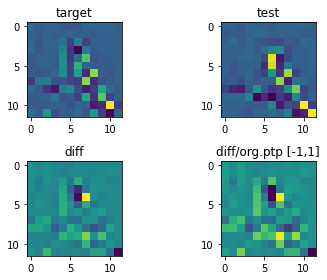

Scale 28.0
chain index 11


In [58]:
dec = util.plot_diff(ocv1, cv1, 32, 32, stride=(2,2), ch=3, out=True, vmin=-1, vmax=1, offset=2)
util.check_ctxt(cv1[0])

In [74]:
after_l1 = layer10(sec, after_l0, nh, nw, org_model.layer1._modules['1'])

Output image size 32 32
Output image size 32 32
Scale 28.0
chain index 10


average diff 7.32%


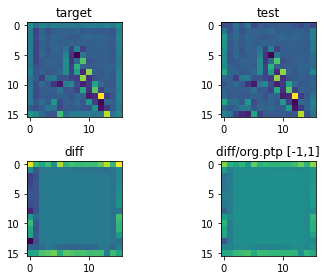

In [80]:
util.plot_diff(ocv1, conv_out, nh, nw, stride=stride)

In [111]:
from fase.nn.conv import *

In [86]:
util.check_ctxt(after_l1[0])

Scale 28.0
chain index 13


In [ ]:
kernel = conv_s.weight
padding="same"
stride=2
ctxts_in = after_l1


if torch.is_tensor(kernel):
    kernel = kernel.detach().numpy()

c_out, c_in, f_h, f_w = kernel.shape

out_nh, out_nw = get_out_size((nh, nw), (f_h, f_w), 
                              stride=stride, 
                              padding=padding)

print("Output image size", out_nh, out_nw)

# rotate each channel
rotated =[]
for channel_enc in ctxts_in:
    img_aug = aug_ctxt(channel_enc, nh, nw, sec)
    rotated.append(rotate_for_conv(img_aug, nw, f_h, f_w, sec))

# Striding uses mask
mask = np.zeros(int(sec.parms.poly_modulus_degree()/2), dtype=int)
if stride == 1:
    mask[:nw*nh] = np.ones(nw*nh)
else :
    _mask = np.zeros((nw,nh))
    _mask[::stride,::stride] = 1.
    mask[:nw*nh] = _mask.ravel()

In [87]:
conv_out=[]
#for this_example in rotated:
for this_kernel_in_channel in kernel:
    # 0 - c_out
    # multi-channel conv sum

    # convolve each channel of image and kernel
    result_each_out_channel = None
    for this_channel, this_kernel in zip(rotated, this_kernel_in_channel):
        # 0 - c_in
        if result_each_out_channel == None:
            result_each_out_channel = convolve_fhe(this_channel, this_kernel, sec)
            #print(sec.decrypt(result_each_out_channel)[:nh*nw].reshape(nh,nw)[14:16,14:16])
        else:
            sec.add(result_each_out_channel,
                    convolve_fhe(this_channel, this_kernel, sec), inplace=True)
        #print(sec.decrypt(result_each_out_channel)[:1024].reshape(32,32)[12:18,12:18])
    #print("_______")
    sec.multByConst(result_each_out_channel, mask, broadcast=False, inplace=True, rescale=True)
    conv_out.append(result_each_out_channel)

Output image size 16 16


average diff 36.83%


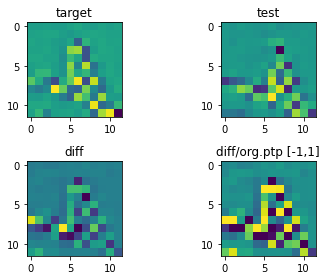

In [105]:
dec = util.plot_diff(ocv1, conv_out, 32, 32, stride=(2,2), ch=31, out=True, vmin=-1, vmax=1, offset=2)

In [117]:
dec = sec.decrypt(conv_out[0])[:1024]

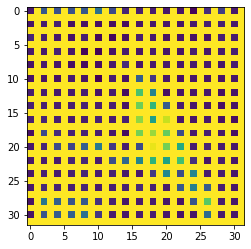

In [119]:
plt.imshow(dec.reshape(32,32))
plt.show()

In [116]:
mask[:1024].reshape(32,32)

array([[1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## strided convolution이기 때문에 값이 띄엄띄엄 있음. 
잘못된게 아님. plot할 때 띄엄띄엄 읽어서 하면 됨. 

average diff 21.98%


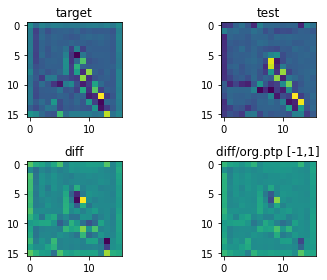

In [101]:
util.plot_diff(ocv1, cv1, 32, 32, ch=3, stride=(2,2))

In [88]:
conv.in_channels
conv.out_channels
conv.kernel_size
conv.stride
conv.padding
conv.groups

<generator object Module.named_parameters at 0x7f9f7ee2ef20>

In [ ]:
def layer20(sec, ctxts_in, nh, nw, this_layer):
    """the size of image must be explicitely given
       (no related info available from the model)
    """
    tmp_l0 = my_conv2D_FHE(sec, ctxts_in, nh, nw, this_layer.conv1.weight)
    tmp0 = fhe_bn(sec, tmp_l0, this_layer.bn1)
    tmp0 = fake_relu(sec, tmp0, nh, nw, this_layer.activation)
    tmp0 = my_conv2D_FHE(sec, tmp0, nh, nw, this_layer.conv2.weight)
    tmp0 = fhe_bn(sec, tmp0, this_layer.bn2)

    # shortcut
    c_out, c_in, kernel_size, stride = this_layer.shortcut[0]
    shortcut = my_conv2D_FHE()
    out = []
    for ctxt0, ctxt1 in zip(tmp0, ctxts_in):
        # Match mod
        sec.match_mod(ctxt1, ctxt0)
        sec.add(ctxt0, ctxt1, inplace=True)
        out.append(ctxt0)

    return fake_relu(sec, out, nh, nw, this_layer.activation)

In [29]:
tmp1 = basic_block(tmp3, nh, nw, org_model.layer1._modules['0'])

t0 = time()
tmp1 = basic_block(tmp1, nh, nw, org_model.layer1._modules['1'])
print(f"done in {time() - t0:.2f}")

Output image size 32 32


TypeError: get_context_data(): incompatible function arguments. The following argument types are supported:
    1. (self: fase.seal.SEALContext, arg0: List[int[4]]) -> fase.seal.ContextData

Invoked with: <fase.seal.SEALContext object at 0x7f31d3d46a30>, <fase.seal.Ciphertext object at 0x7f311b8f5730>

In [94]:
def get_bn_params(bn_dict):
    gamma = bn_dict['weight'].detach().cpu().numpy()
    beta = bn_dict['bias'].detach().cpu().numpy()
    running_mean = bn_dict['running_mean'].detach().cpu().numpy()
    running_var = bn_dict['running_var'].detach().cpu().numpy()

    return gamma, beta, running_mean, running_var

In [136]:
# basic_block 2 with Conv-ed short cut

layer_parms = org_model.layer2._modules['0']

# First and shortcut conv have stride=2
tmp0 = my_conv2D_FHE(sec, ctxts_in, nh, nw, layer_parms.conv1.weight, stride=layer_parms.conv1.stride[0])
tmp0 = fhe_bn(sec, tmp0, layer_parms.bn1)
tmp0 = approx_relu(tmp0)
tmp0 = my_conv2D_FHE(sec, tmp0, nh, nw, layer_parms.conv2.weight)
#tmp0 = fhe_bn(sec, tmp0, *get_bn_params(layer_parms.bn2.state_dict()))
tmp0 = fhe_bn(sec, tmp0, layer_parms.bn2)

short_conv = layer_parms.shortcut[0]
short_bn = layer_parms.shortcut[1]
shortcut = ctxts_intmp0 = my_conv2D_FHE(sec, ctxts_in, nh, nw, 
                                        short_conv.weight, 
                                        stride = short_conv.stride[0])
shortcut = fhe_bn(sec, shortcut, short_bn)
# Skip connection
out = []
for ctxt0, ctxt1 in zip(tmp0, shortcut):
    # Match mod
    sec.match_mod(ctxt1, ctxt0)
    out.append(sec.add(ctxt0, ctxt1, inplace=True))

tmp0 = approx_relu(tmp0)




Output image size 32 32


ValueError: scale out of bounds

In [ ]:
def FHE_BasicBlock(trained_model, stride=1, activation=F.relu):
    
    self.conv1 = # weight랑 ...
    conv_kernel = org_model.conv1.state_dict()['weight']
    
    # nh와 nw가 필요함. 
    
    tmp1 = my_conv2D_FHE(sec, img_enc, nh, nw, conv_kernel)
    
    self.bn1 = # fhe_bn(sec, tmp1, org_model.bn1.state_dict())
    

In [ ]:
def act_bn_conv(ctxts):
    

In [26]:
tmp3 = fhe_avg_pool(sec, tmp2, nh, nw, kernel_size=org_model.avgpool.kernel_size)

Output image size 16 16


running_mean, running_var 다름...?

In [31]:
def cal_bn(xin, mean, var, weight, bias, eps=1e-5):
    xhat = (xin - mean) / np.sqrt(var + eps)
    xhat = xhat * weight + bias
    return xhat


def cal_bn2(xin, mean, var, weight, bias, eps=1e-5):
    denom = np.sqrt(var + eps)
    xx = xin * (weight / denom)
    const = -mean/denom*weight + bias
    xhat = xx + const

    return xhat

def cal_bn2(xin, mean, var, weight, bias, eps=1e-5):
    denom = np.sqrt(var + eps)
    factor = (weight / denom)
    const = -mean/denom*weight + bias
    print(factor, const)
    xhat = factor * xin + const
    return xhat